In [93]:
import cv2
import numpy as np
import scipy
from scipy.misc import imread
import pickle
import random
import os
import matplotlib.pyplot as plt

In [94]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imread(image_path, mode="RGB")
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc

In [95]:
images_path = "image/ec1m_00010001.jpg"

In [96]:

features = extract_features(images_path)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


In [97]:
features

array([0.03429585, 0.01655692, 0.05309892, ..., 0.02748357, 0.03974283,
       0.07194637], dtype=float32)

In [98]:

def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    
    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    print (result)
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)
batch_extractor("image/")

Extracting features from image image/ec1m_00010001.jpg


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


Extracting features from image image/ec1m_00010002.jpg
Extracting features from image image/ec1m_00010003.jpg
Extracting features from image image/ec1m_00010004.jpg
Extracting features from image image/ec1m_00010005.jpg
Extracting features from image image/ec1m_00010006.jpg
Extracting features from image image/ec1m_00010007.jpg
Extracting features from image image/ec1m_00010008.jpg
Extracting features from image image/ec1m_00010009.jpg
Extracting features from image image/ec1m_00010010.jpg
Extracting features from image image/ec1m_00010011.jpg
Extracting features from image image/ec1m_00010012.jpg
Extracting features from image image/ec1m_00010013.jpg
Extracting features from image image/ec1m_00010014.jpg
Extracting features from image image/ec1m_00010015.jpg
Extracting features from image image/ec1m_00010016.jpg
Extracting features from image image/ec1m_00010017.jpg
Extracting features from image image/ec1m_00010018.jpg
Extracting features from image image/ec1m_00010019.jpg
Extracting

In [99]:
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path, 'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

In [100]:
ma = Matcher('features.pck')

In [101]:
def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()

In [105]:
names, match = ma.match("image/ec1m_00170069.jpg", topn=3)
names, match

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


(['ec1m_00170069.jpg', 'ec1m_00010001.jpg', 'ec1m_00010013.jpg'],
 [0.0, 0.46556483498388557, 0.47325589538481583])

In [106]:
def test():
    images_path = 'image/'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting 3 random images 
    sample = random.sample(files, 3)
    
    batch_extractor(images_path)

    ma = Matcher('features.pck')
    
    for s in sample:
        print ('Query image ==========================================')
        show_img(s)
        names, match = ma.match(s, topn=10)
        print ('Result images ========================================')
        for i in range(3):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print ('Match %s' % (1-match[i]))
            show_img(os.path.join(images_path, names[i]))

Extracting features from image image/ec1m_00010001.jpg


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


Extracting features from image image/ec1m_00010002.jpg
Extracting features from image image/ec1m_00010003.jpg
Extracting features from image image/ec1m_00010004.jpg
Extracting features from image image/ec1m_00010005.jpg
Extracting features from image image/ec1m_00010006.jpg
Extracting features from image image/ec1m_00010007.jpg
Extracting features from image image/ec1m_00010008.jpg
Extracting features from image image/ec1m_00010009.jpg
Extracting features from image image/ec1m_00010010.jpg
Extracting features from image image/ec1m_00010011.jpg
Extracting features from image image/ec1m_00010012.jpg
Extracting features from image image/ec1m_00010013.jpg
Extracting features from image image/ec1m_00010014.jpg
Extracting features from image image/ec1m_00010015.jpg
Extracting features from image image/ec1m_00010016.jpg
Extracting features from image image/ec1m_00010017.jpg
Extracting features from image image/ec1m_00010018.jpg
Extracting features from image image/ec1m_00010019.jpg
Extracting

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


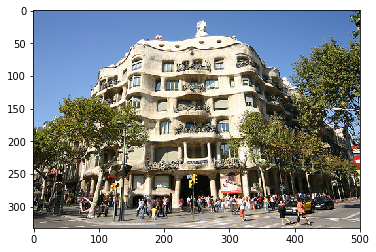

Result images ========================================
Match 1.0


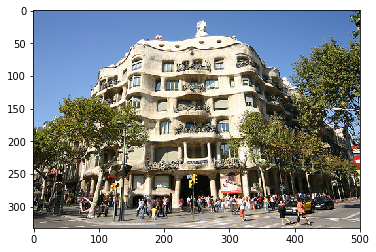

Match 0.8257208793614237


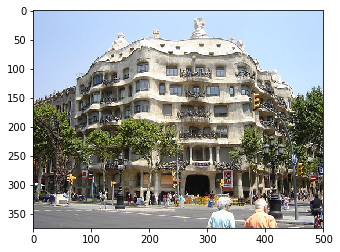

Match 0.821163617104298


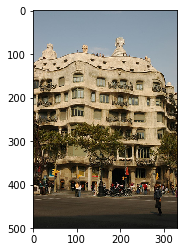

Query image ==========================================


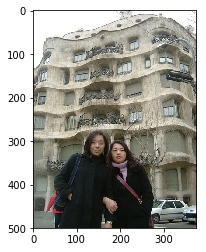

Result images ========================================
Match 1.0


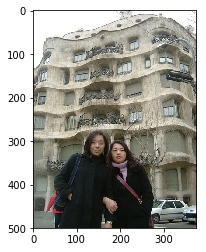

Match 0.7627072370747047


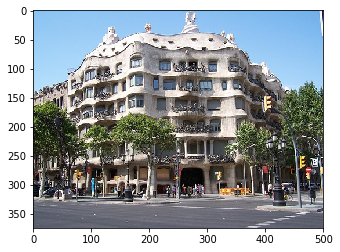

Match 0.7602864333956423


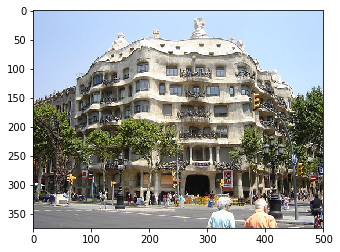

Query image ==========================================


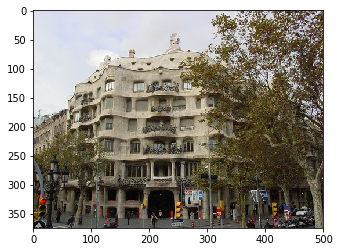

Result images ========================================
Match 0.9999999999999999


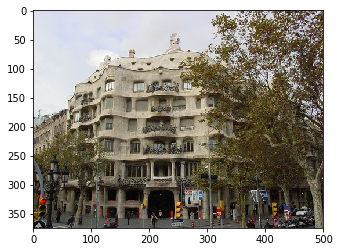

Match 0.8117770870695358


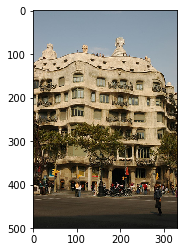

Match 0.8099508977203511


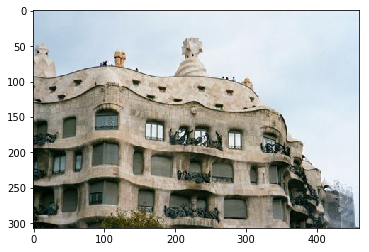

In [107]:
test()